In [1]:
import sys, os

ILU_HOME = "../../.."

sys.path.append(os.path.join(ILU_HOME, ".."))
from load.run.run_trace import rust_build, run_live, RunTarget, BuildTarget, LOCALHOST_Q

In [ ]:
CORES = 2
MEMORY = 4096
build_level = BuildTarget.RELEASE
worker_log_dir = os.path.join(os.getcwd(), "temp_results")
results_dir = os.path.join(os.getcwd(), "results")
benchmark = "../benchmark/worker_function_benchmarks.json"
ansible_dir = os.path.join(ILU_HOME, "ansible")

kwargs = {
    "ilu_home": ILU_HOME,
    "ansible_hosts_addrs": "@"
    + os.path.join(ansible_dir, "group_vars/local_addresses.yml"),
    "ansible_dir": ansible_dir,
    "build_level": build_level,
    "cores": CORES,
    "memory": MEMORY,
    "worker_status_ms": 500,
    "worker_log_dir": worker_log_dir,
    "cpu_queue_policy": "fcfs",
    "target": RunTarget.WORKER,
    "prewarm": 1,
    "snapshotter": "overlayfs",
    "benchmark_file": benchmark,
    # "force": True,
    "enqueuing_log_details": True,
}

input_csv = "./in.csv"
meta_csv = "./meta.csv"

In [0]:
os.makedirs(results_dir, exist_ok=True)
os.makedirs(worker_log_dir, exist_ok=True)
# build the solution
rust_build(ILU_HOME, None, build_level)

In [0]:
# run entire experiment
run_live(input_csv, meta_csv, results_dir, LOCALHOST_Q, **kwargs)

Index(['success', 'function_name', 'was_cold', 'worker_duration_us',
       'code_duration_sec', 'e2e_duration_us', 'compute', 'state',
       'invoke_sent', 'invoke_return', 'queueing_sec', 'insert', 'remove',
       'queue_exec_sec', 'cpu_est_sec', 'gpu_est_sec', 'insert_cpu_load',
       'insert_gpu_load', 'est_sec_diff', 'start', 'end', 'e2e_overhead',
       'exec_overhead', 'norm_e2e', 'e2e_overhead_portion', 'e2e_sec',
       'queue_portion', 'exec_overhead_norm', 'e2e_portion',
       'e2e_norm_portion'],
      dtype='object')
count    9.000000
mean    -0.350474
std      0.329108
min     -0.816333
25%     -0.649679
50%     -0.258293
75%     -0.000487
max     -0.000070
Name: est_sec_diff, dtype: float64
       cold_dur_ms  warm_dur_ms  mem_mb  prewarms  avg_iat  iat_class
count          2.0          2.0     2.0  2.000000     2.00        2.0
mean        5000.0        500.0   512.0  1.500000  2499.75        0.0
std            0.0          0.0     0.0  0.707107     0.00        0.0


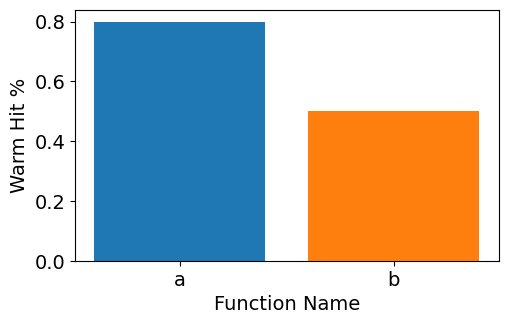

<Figure size 640x480 with 0 Axes>

In [ ]:
## plot some results
from load.analysis import WorkerLogParser
from load.run.run_trace import RunTarget, RunType
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


parser = WorkerLogParser(
    results_dir, input_csv, meta_csv, benchmark, RunType.LIVE, RunTarget.WORKER
)
parser.parse_logs(fail_if_errors=False)
print(parser.invokes_df.columns)
print(parser.invokes_df["est_sec_diff"].describe())
print(parser.metadata_df.describe())

fig, ax = plt.subplots()
plt.tight_layout()
fig.set_size_inches(5, 3)

labels = []
for i, (func, df) in enumerate(parser.invokes_df.groupby("function_name")):
    ax.bar(i, height=len(df[~df["was_cold"]]) / len(df))
    labels.append(func)


ax.set_xticks(list(range(len(labels))))
ax.set_xticklabels(labels)
ax.set_ylabel("Warm Hit %")
ax.set_xlabel("Function Name")
plt.show()
plt.savefig(os.path.join(results_dir, "warm_hits.png"), bbox_inches="tight")
plt.close(fig)
